In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
from google.cloud import storage
import json
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from datetime import timedelta

# Preprocessing Various Excel Files

## COE (Target Variable)

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./car-resale-capstone-secret-key.json"

# Initialize the client (auth automatically detected from environment variable)
client = storage.Client()

# Name of your bucket
bucket_name = "car-resale-bucket"

# Path to the file in GCS
source_blob_name = "/datasets/coe.csv"

uri = f"gs://{bucket_name}/datasets/coe.csv"

df_coe = pd.read_csv(f"{uri}")
df_coe.head()

,Bidding_Date,Vehicle_Class,Quota,Bids_Success,Bids_Received,Premium
0,2010-01-06,Category A,1152,1145,1342,18502
1,2010-01-06,Category B,687,679,883,19190
2,2010-01-06,Category C,173,173,265,19001
3,2010-01-06,Category D,373,365,509,889
4,2010-01-06,Category E,586,567,1011,19889


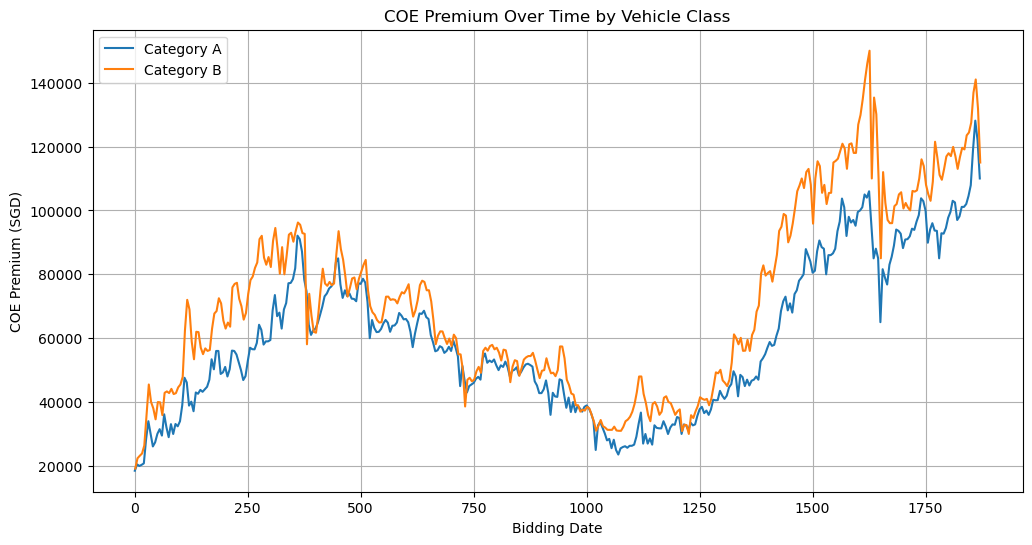

In [4]:
# no missing Premiums so create time plot by vehicle class
df_coe_a = df_coe[df_coe['Vehicle_Class'] == 'Category A']
df_coe_b = df_coe[df_coe['Vehicle_Class'] == 'Category B']


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coe_a, x=df_coe_a.index, y='Premium', label='Category A')
sns.lineplot(data=df_coe_b, x=df_coe_b.index, y='Premium', label='Category B')
plt.title('COE Premium Over Time by Vehicle Class')
plt.xlabel('Bidding Date')
plt.ylabel('COE Premium (SGD)')
plt.legend()
plt.grid(True)
plt.show()


# Training and Validation

In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [6]:
# get pct change
df_coe_a_copy = df_coe_a.copy()
df_coe_a_copy['Premium_diff'] = df_coe_a_copy['Premium'].diff()
df_coe_a_copy = df_coe_a_copy.dropna()

df_coe_b_copy = df_coe_b.copy()
df_coe_b_copy['Premium_diff'] = df_coe_b_copy['Premium'].diff()
df_coe_b_copy = df_coe_b_copy.dropna()

In [7]:
def test_stationarity(series, name="Series"):
    result = adfuller(series)
    print(f"Results for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"  Critical Value ({key}): {value:.4f}")
    if result[1] < 0.05:
        print(f"✅ {name} is likely stationary (reject H₀)\n")
    else:
        print(f"❌ {name} is likely non-stationary (fail to reject H₀)\n")

test_stationarity(df_coe_a_copy['Premium_diff'], "Premium_diff A")
test_stationarity(df_coe_b_copy['Premium_diff'], "Premium_diff B")

Results for Premium_diff A:
  ADF Statistic: -8.9004
  p-value: 0.0000
  Critical Value (1%): -3.4483
  Critical Value (5%): -2.8695
  Critical Value (10%): -2.5710
✅ Premium_diff A is likely stationary (reject H₀)

Results for Premium_diff B:
  ADF Statistic: -10.5955
  p-value: 0.0000
  Critical Value (1%): -3.4482
  Critical Value (5%): -2.8694
  Critical Value (10%): -2.5710
✅ Premium_diff B is likely stationary (reject H₀)



# Short Term Arima

In [8]:
# --- Paste your arima_rolling_validation function here ---
import warnings

warnings.filterwarnings("ignore")

def arima_rolling_multihorizon_aligned_preds(
    df,
    value_col,
    start_val_date,
    end_val_date,
    order=(1,0,0),
    max_horizon=5
):
    """
    Rolling-origin multi-horizon ARIMA forecast evaluation with aligned predictions.
    Each h-step forecast is shifted to the row corresponding to the actual date it predicts.

    Returns:
    - mae_dict: MAE per horizon
    - actual_vals: actual validation values
    - aligned_preds_df: forecasts aligned with their future target dates
    - val_dates: validation dates
    - horizons: list of horizons
    """

    # Ensure datetime index
    if "Bidding_Date" in df.columns:
        df = df.set_index("Bidding_Date")
    df.index = pd.to_datetime(df.index)

    val_dates = df.loc[start_val_date:end_val_date].index
    horizons = list(range(1, max_horizon + 1))

    # Initialize aligned predictions with NaNs
    aligned_preds = pd.DataFrame(index=df.index, columns=[f"h{h}" for h in horizons], dtype=float)

    # Rolling forecast
    for current_date in val_dates:
        train_data = df.loc[:current_date - pd.Timedelta(days=1), value_col]

        model = SARIMAX(train_data, order=order)
        fitted = model.fit(disp=False)

        fc = fitted.forecast(steps=max_horizon)

        # Shift forecast into aligned rows
        for h in horizons:
            future_idx = df.index.get_loc(current_date) + h - 1
            if future_idx < len(df):
                aligned_preds.iloc[future_idx, h-1] = fc.iloc[h-1]

    # Extract actual values for validation period
    actual_vals = df.loc[val_dates, value_col]

    # Compute MAE per horizon
    mae_dict = {}
    for h in horizons:
        valid_mask = ~aligned_preds[f"h{h}"].isna()
        mae_dict[f"h{h}"] = mean_absolute_error(df[value_col][valid_mask], aligned_preds[f"h{h}"][valid_mask])

    # Only keep aligned predictions within validation range
    aligned_preds_df = aligned_preds.loc[val_dates]

    return mae_dict, actual_vals.values, aligned_preds_df, val_dates, horizons

def plot_multihorizon_validation_array(
    preds_array,
    actual_vals,
    val_dates,
    horizons=None,
    title="Rolling Multi-Horizon Forecast",
    figsize=(14,6)
):
    import matplotlib.pyplot as plt
    import numpy as np

    preds_array = np.array(preds_array)
    actual_vals = np.array(actual_vals)

    # Ensure 2D array
    if preds_array.ndim == 1:
        preds_array = preds_array.reshape(-1, 1)

    plt.figure(figsize=figsize)

    # Plot actual values
    plt.plot(val_dates, actual_vals, label="Actual", color="black", linewidth=2)

    # Determine horizons
    if horizons is None:
        horizons = list(range(1, preds_array.shape[1]+1))

    # Plot each horizon
    for h in horizons:
        h_idx = h-1
        if h_idx < preds_array.shape[1]:
            plt.plot(val_dates, preds_array[:, h_idx], linestyle='--', label=f"{h}-Step Forecast")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [9]:
# mae_a, acts_a, preds_a, dates_a, horizons_a = arima_rolling_multihorizon_aligned_preds(
#     df_coe_a_copy,
#     value_col='Premium',
#     start_val_date='2023-08-18',
#     end_val_date='2024-05-08',
#     order=(2,1,2),
#     max_horizon=12)

# plot_multihorizon_validation_array(
#     preds_a.values,
#     acts_a,
#     dates_a,
#     horizons=[1, 3, 6, 12],
#     title="Category A Multi-Horizon ARIMA Forecasts"
# )


In [14]:
# --- The Grid Search Loop ---
# Define the range of p and q to test
p_range = range(0, 6) # Test p from 0 to 3
q_range = range(0, 6) # Test q from 0 to 3

best_mae = float('inf')
best_order = None

print("\n--- Starting Grid Search ---")
best_mae_a, best_order_a = float('inf'), None
best_mae_b, best_order_b = float('inf'), None

print("\n--- Starting Grid Search ---")
start_val_date = '2022-08-18'
end_val_date = '2024-05-08'
horizons = 4
for p in p_range:
    for q in q_range:
        current_order = (p, 1, q)
        print(f"\nTesting order {current_order}...")
        # actual_vals, preds_df, val_dates, horizons
        # Rolling validation for dataset A
        mae_a, acts_a, preds_a, dates_a, horizons_a = arima_rolling_multihorizon_aligned_preds(df_coe_a_copy,
                                                    value_col='Premium',
                                                    start_val_date=start_val_date,
                                                    end_val_date=end_val_date,
                                                    order=current_order,
                                                    max_horizon=horizons
                                                    )
        
        # Rolling validation for dataset B
        mae_b, acts_b, preds_b, dates_b, horizons_b = arima_rolling_multihorizon_aligned_preds(df_coe_b_copy,
                                                    value_col='Premium',
                                                    start_val_date=start_val_date,
                                                    end_val_date=end_val_date,
                                                    order=current_order,
                                                    max_horizon=horizons
                                                    )
        
        mean_mae_a = sum(mae_a.values()) / len(mae_a)
        print(f"  -> Mean MAE (A): {mean_mae_a:.3f}")

        mean_mae_b = sum(mae_b.values()) / len(mae_b)
        print(f"  -> Mean MAE (B): {mean_mae_b:.3f}")

        # Update best model for A
        if mean_mae_a < best_mae_a:
            best_mae_a = mean_mae_a
            best_order_a = current_order
            print("  ⭐ New best MAE for A found!")

        # Update best model for B
        if mean_mae_b < best_mae_b:
            best_mae_b = mean_mae_b
            best_order_b = current_order
            print("  ⭐ New best MAE for B found!")

print("\n--- Grid Search Complete ---")
print(f"Best ARIMA order for A: {best_order_a} | Lowest MAE: {best_mae_a:.3f}")
print(f"Best ARIMA order for B: {best_order_b} | Lowest MAE: {best_mae_b:.3f}")


--- Starting Grid Search ---

--- Starting Grid Search ---

Testing order (0, 1, 0)...
  -> Mean MAE (A): 6335.683
  -> Mean MAE (B): 9261.689
  ⭐ New best MAE for A found!
  ⭐ New best MAE for B found!

Testing order (0, 1, 1)...
  -> Mean MAE (A): 6349.366
  -> Mean MAE (B): 9176.784
  ⭐ New best MAE for B found!

Testing order (0, 1, 2)...
  -> Mean MAE (A): 6347.034
  -> Mean MAE (B): 9169.212
  ⭐ New best MAE for B found!

Testing order (0, 1, 3)...
  -> Mean MAE (A): 6332.702
  -> Mean MAE (B): 9263.792
  ⭐ New best MAE for A found!

Testing order (0, 1, 4)...
  -> Mean MAE (A): 6364.069
  -> Mean MAE (B): 9273.705

Testing order (0, 1, 5)...
  -> Mean MAE (A): 6266.538
  -> Mean MAE (B): 9073.361
  ⭐ New best MAE for A found!
  ⭐ New best MAE for B found!

Testing order (1, 1, 0)...
  -> Mean MAE (A): 6346.435
  -> Mean MAE (B): 9189.418

Testing order (1, 1, 1)...
  -> Mean MAE (A): 6328.987
  -> Mean MAE (B): 9165.074

Testing order (1, 1, 2)...
  -> Mean MAE (A): 6325.532
  

In [16]:
best_order_a
best_order_b

(0, 1, 5)

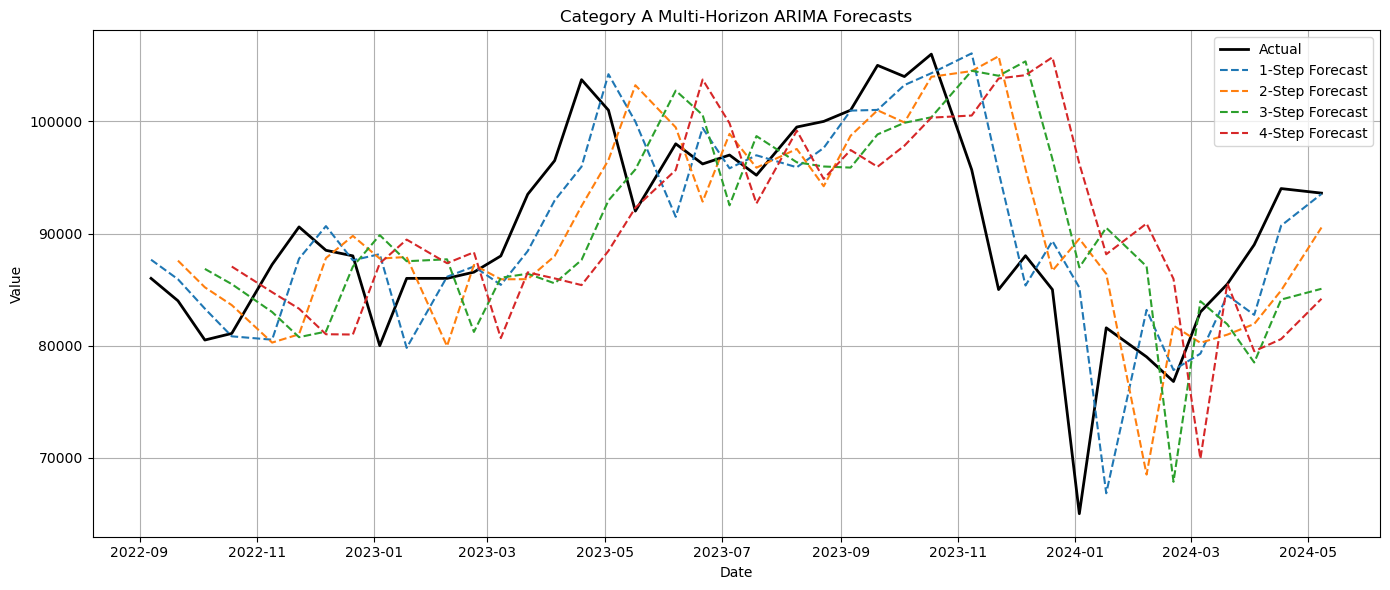

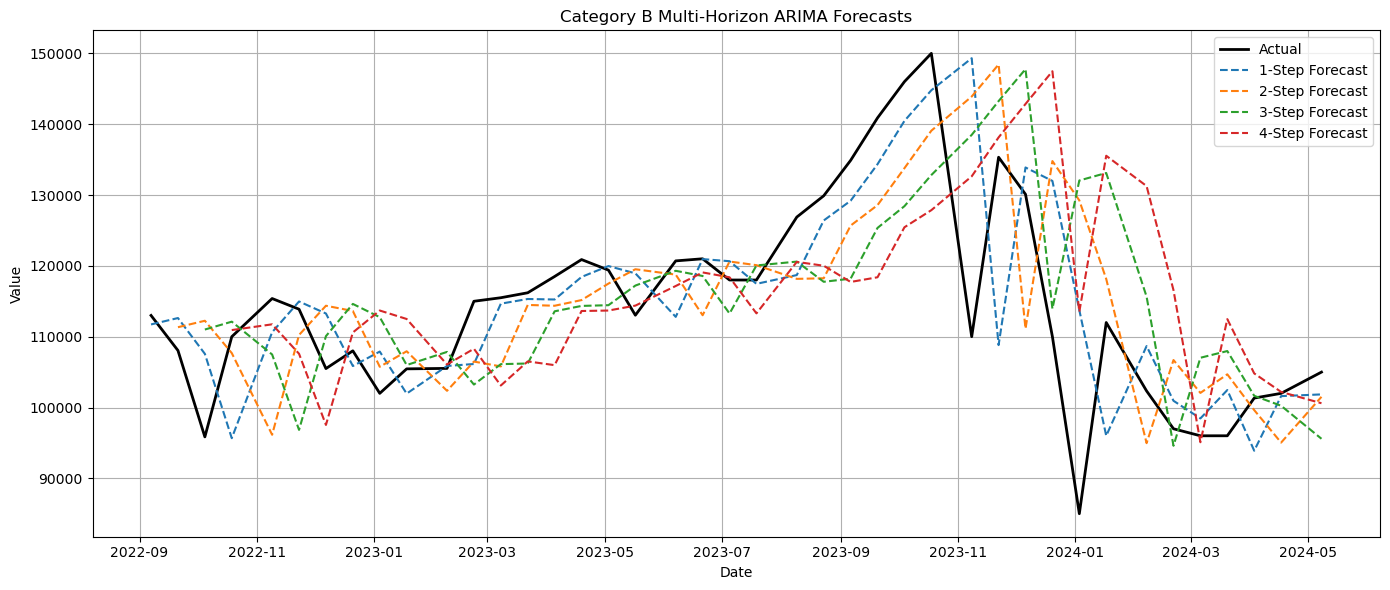

In [17]:
mae_a, acts_a, preds_a, dates_a, horizons_a = arima_rolling_multihorizon_aligned_preds(df_coe_a_copy,
                                                    value_col='Premium',
                                                    start_val_date=start_val_date,
                                                    end_val_date=end_val_date,
                                                    order=best_order_a,
                                                    max_horizon=horizons
                                                    )

plot_multihorizon_validation_array(
    preds_a.values,
    acts_a,
    dates_a,
    horizons=[1, 2, 3, 4],
    title="Category A Multi-Horizon ARIMA Forecasts"
)
        
# Rolling validation for dataset B
mae_b, acts_b, preds_b, dates_b, horizons_b = arima_rolling_multihorizon_aligned_preds(df_coe_b_copy,
                                            value_col='Premium',
                                            start_val_date=start_val_date,
                                            end_val_date=end_val_date,
                                            order=best_order_b,
                                            max_horizon=horizons
                                            )

plot_multihorizon_validation_array(
    preds_b.values,
    acts_b,
    dates_b,
    horizons=[1, 2, 3, 4],
    title="Category B Multi-Horizon ARIMA Forecasts"
)

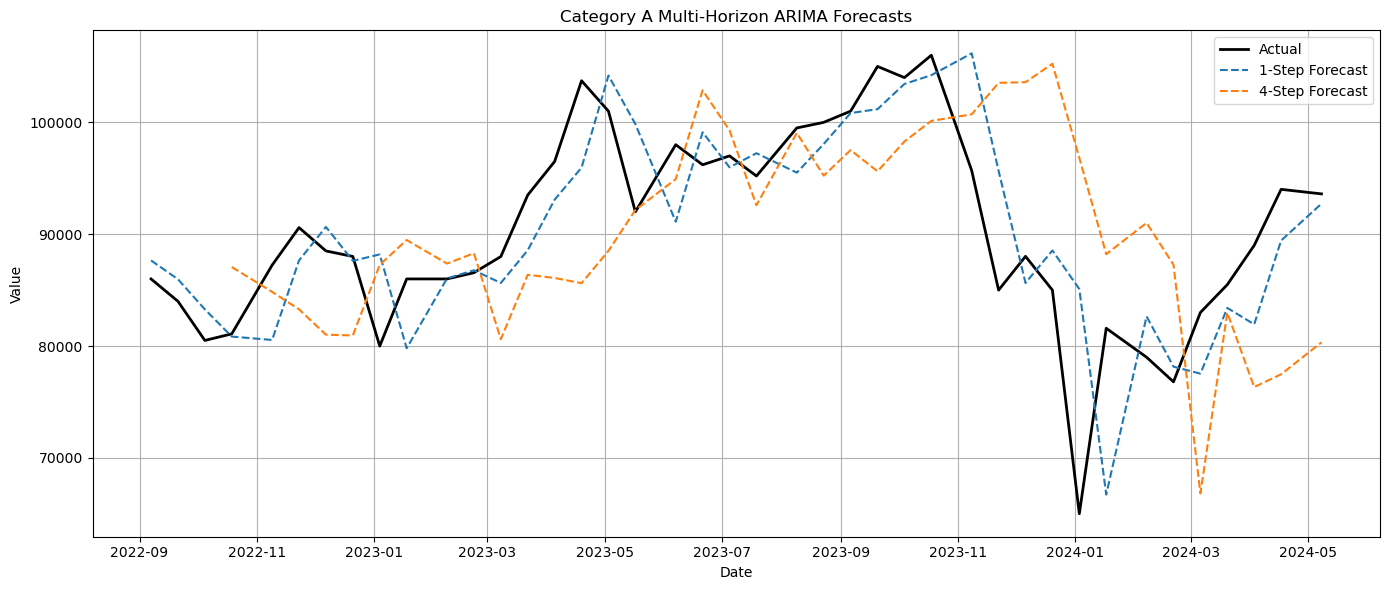

In [15]:
plot_multihorizon_validation_array(
    preds_a.values,
    acts_a,
    dates_a,
    horizons=[1, 4],
    title="Category A Multi-Horizon ARIMA Forecasts"
)

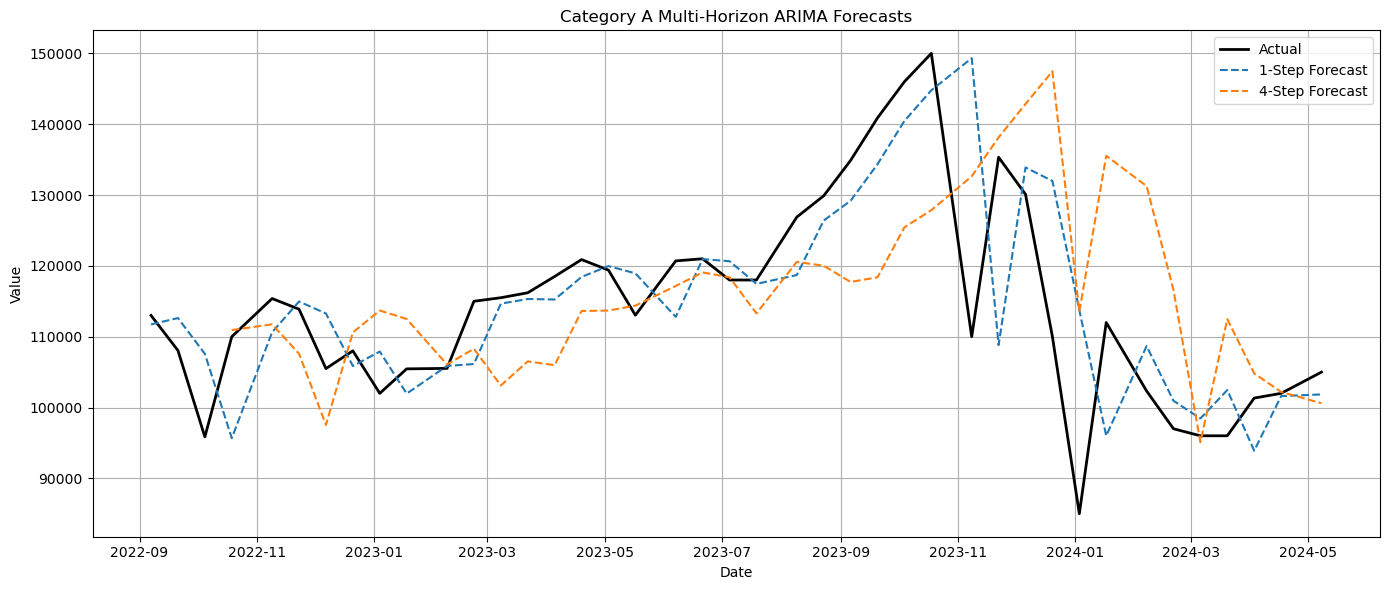

In [18]:
plot_multihorizon_validation_array(
    preds_b.values,
    acts_b,
    dates_b,
    horizons=[1, 4],
    title="Category A Multi-Horizon ARIMA Forecasts"
)

In [20]:
def arima_longterm_validation(df,
                              value_col,
                              start_val_date,
                              end_val_date,
                              order=(1,1,1),
                              seasonal=False,
                              m=0,
                              verbose=False,
                              plot=False):
    """
    Performs long-term (direct multi-step) validation for ARIMA using date-based split.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime index and the target value column.
    value_col : str
        Name of the target column to forecast.
    start_val_date : str or pd.Timestamp
        Start date of validation period.
    end_val_date : str or pd.Timestamp
        End date of validation period.
    order : tuple
        ARIMA(p,d,q) order.
    seasonal : bool, default=False
        Whether to include seasonal terms.
    m : int, default=0
        Seasonal period if seasonal=True.
    verbose : bool, default=False
        Whether to print step-by-step forecast results.
    plot : bool, default=False
        Whether to plot forecast vs. actuals.

    Returns
    -------
    mae : float
        Mean absolute error over validation horizon.
    errors : np.ndarray
        Absolute errors for each step.
    preds : np.ndarray
        Forecasted values.
    actuals : np.ndarray
        Actual validation values.
    """

    df = df.copy()
    df.index = pd.to_datetime(df['Bidding_Date'])

    # --- 1. Split into training and validation ---
    df_train = df[df.index < start_val_date]
    df_val = df[(df.index >= start_val_date) & (df.index <= end_val_date)]

    if df_train.empty or df_val.empty:
        raise ValueError("Training or validation period is empty. Check your start/end dates.")

    y_train = df_train[value_col]
    y_val = df_val[value_col]
    n_forecast = len(y_val)

    # --- 2. Fit ARIMA model on training data ---
    model = SARIMAX(
        endog=y_train,
        order=order,
        seasonal_order=(0,0,0,0) if not seasonal else (order[0], order[1], order[2], m)
    ).fit(disp=False)

    # --- 3. Forecast entire validation horizon ---
    forecast_prices = model.get_forecast(steps=n_forecast).predicted_mean
    preds = forecast_prices.values
    actuals = y_val.values

    # --- 4. Compute MAE ---
    errors = np.abs(actuals - preds)
    mae = np.mean(errors)

    # --- 5. Verbose output ---
    if verbose:
        for i, (pred, actual, err) in enumerate(zip(preds, actuals, errors)):
            print(f"{df_val.index[i].date()} | Pred={pred:.2f}, Actual={actual:.2f}, Error={err:.2f}")

    # --- 6. Plot if requested ---
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(df_val.index, actuals, label="Actual (Validation)", color="black")
        plt.plot(df_val.index, preds, label="Forecast", color="red")
        plt.title(f"ARIMA Long-Term Forecast ({start_val_date} → {end_val_date}) — MAE = {mae:.3f}")
        plt.legend()
        plt.show()

    return mae, errors, preds, actuals

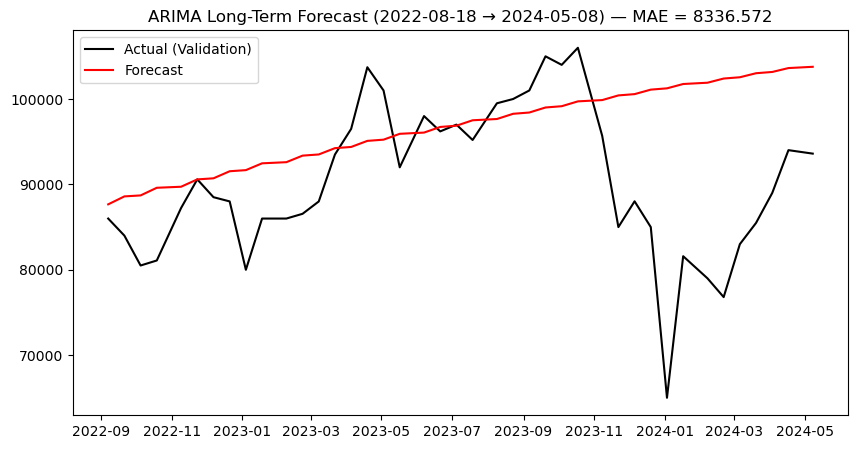

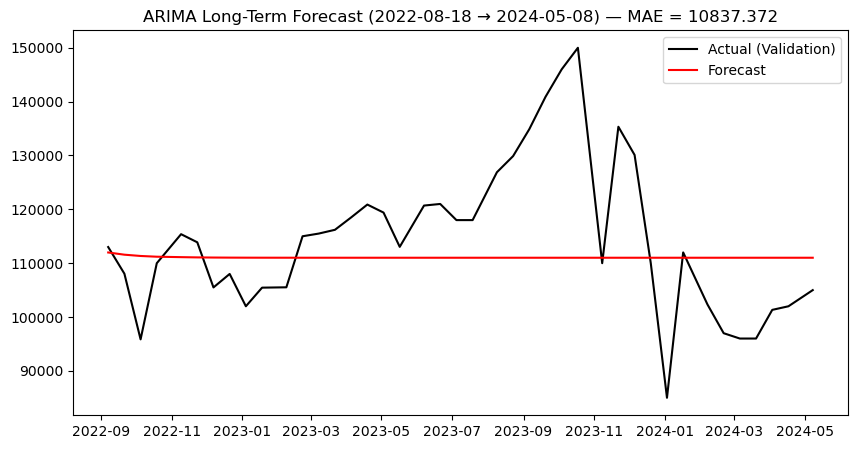

(10837.372470011362,
 array([ 1008.74794231,  3529.24625404, 15485.99491397,  1203.88566943,
         4264.17332803,  2803.58182946,  5549.51614736,  3028.92161556,
         9023.8817965 ,  5561.64160528,  5493.60397766,  3985.15687059,
         4486.17759695,  5186.76929035,  7487.11228245,  9875.3111077 ,
         8385.42636247,  2020.49317322,  9688.53190199,  9986.55435223,
         6988.56736616,  6987.57491006, 15875.5792831 , 18876.58181806,
        23875.58328752, 29875.58413934, 34988.58463312, 38987.58491935,
         1012.41491473, 24322.58518146, 19086.58523721,  1012.41473047,
        26003.41471174,   986.58529913,  8675.41469458, 14013.41469093,
        15003.41468881, 15002.41468759,  9679.41468688,  9012.41468647,
         6011.41468623]),
 array([111991.25205769, 111580.24625404, 111341.99491397, 111203.88566943,
        111123.82667197, 111077.41817054, 111050.51614736, 111034.92161556,
        111025.8817965 , 111020.64160528, 111017.60397766, 111015.84312941,
     

In [21]:
arima_longterm_validation(df_coe_a_copy, value_col='Premium', 
                         start_val_date='2022-08-18', end_val_date='2024-05-08', 
                                             order=(2,1,3), plot=True)

arima_longterm_validation(df_coe_b_copy, value_col='Premium', 
                         start_val_date='2022-08-18', end_val_date='2024-05-08', 
                                             order=(1,1,2), plot=True)

## ARIMAX with Long Term Trends

In [27]:
def fourier_features(df, period, order):
    """
    Create Fourier series terms for a given period and order.
    - df: DataFrame containing your time index
    - time_col: column name containing timestamps or integer index
    - period: number of observations per cycle (e.g., 12 for monthly data with yearly seasonality)
    - order: number of sine/cosine pairs
    """
    t = np.arange(len(df))
    X = pd.DataFrame(index=df.index)
    for k in range(1, order + 1):
        X[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        X[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return X

df_fourier_a = fourier_features(df_coe_a_copy, 240, 1)
df_fourier_b = fourier_features(df_coe_b_copy, 240, 1)

# Concatenate Fourier features to the main DataFrame
df_coe_a_exog = pd.concat([df_coe_a_copy, df_fourier_a], axis=1)
df_coe_b_exog = pd.concat([df_coe_b_copy, df_fourier_b], axis=1)


In [28]:
def arima_rolling_validation_exog(df,
                                  value_col,
                                  start_val_date,
                                  end_val_date,
                                  order=(1,0,1),
                                  seasonal=False,
                                  m=0,
                                  exog_cols=None,
                                  verbose=False,
                                  plot=False):
    """
    Performs rolling (walk-forward) validation for ARIMA with optional exogenous variables.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime index or a 'Bidding_Date' column.
    value_col : str
        Name of the target column.
    start_val_date : str or pd.Timestamp
        Start date of validation period.
    end_val_date : str or pd.Timestamp
        End date of validation period.
    order : tuple
        ARIMA(p,d,q) order.
    seasonal : bool
        Whether to include seasonal terms.
    m : int
        Seasonal period if seasonal=True.
    exog_cols : list of str
        Columns to use as exogenous variables (optional).
    verbose : bool
        Print progress step-by-step.
    plot : bool
        Plot forecast vs. actuals.

    Returns
    -------
    mae : float
        Mean absolute error.
    errors, preds, actuals, val_dates : lists
        Rolling errors, predicted values, actual values, and validation dates.
    """

    df = df.copy()
    if 'Bidding_Date' in df.columns:
        df.index = pd.to_datetime(df['Bidding_Date'])
    else:
        df.index = pd.to_datetime(df.index)

    # Split training and validation
    df_train = df[df.index < start_val_date]
    df_val = df[(df.index >= start_val_date) & (df.index <= end_val_date)]
    y_full = pd.concat([df_train, df_val])
    train_end_idx = len(df_train)

    errors, preds, actuals, val_dates = [], [], [], []

    for t in range(train_end_idx, len(y_full)):
        train_slice = y_full.iloc[:t]
        val_date = y_full.index[t]

        # Slice exogenous variables if provided
        exog_train = train_slice[exog_cols] if exog_cols else None
        exog_forecast = y_full.iloc[t:t+1][exog_cols] if exog_cols else None

        model = SARIMAX(
            endog=train_slice[value_col],
            exog=exog_train,
            order=order,
            seasonal_order=(0,0,0,m) if not seasonal else (order[0], order[1], order[2], m)
        ).fit(disp=False)

        forecast_price = model.get_forecast(steps=1, exog=exog_forecast).predicted_mean.iloc[0]
        actual_price = y_full[value_col].iloc[t]
        abs_error = abs(actual_price - forecast_price)

        errors.append(abs_error)
        preds.append(forecast_price)
        actuals.append(actual_price)
        val_dates.append(val_date)

        if verbose:
            print(f"{val_date.date()} | Pred={forecast_price:.2f}, Actual={actual_price:.2f}, Error={abs_error:.2f}")

    mae = np.mean(errors)

    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(val_dates, actuals, label="Actual (Validation)", color="black")
        plt.plot(val_dates, preds, label="Rolling Forecast", color="red")
        plt.title(f"Rolling Validation ({start_val_date} → {end_val_date}) — MAE = {mae:.3f}")
        plt.legend()
        plt.show()

    return mae, errors, preds, actuals, val_dates


In [30]:
p_range = range(0, 5)
q_range = range(0, 5)

best_mae_a, best_order_a = float('inf'), None
best_mae_b, best_order_b = float('inf'), None

exog_vars = ['sin_1', 'cos_1']  # example
warnings.filterwarnings('ignore')
for p in p_range:
    for q in q_range:
        current_order = (p, 1, q)
        print(f"\nTesting order {current_order}...")

        # Rolling validation for dataset A
        try:
            mae_a, _, _, _, _ = arima_rolling_validation_exog(
                df_coe_a_exog,
                value_col='Premium',
                start_val_date='2022-08-18',
                end_val_date='2024-05-08',
                order=current_order,
                exog_cols=exog_vars
            )
        except Exception as e:
            print(e)
            mae_a = float('inf')

        # Rolling validation for dataset B
        try:
            mae_b, _, _, _, _ = arima_rolling_validation_exog(
                df_coe_b_exog,
                value_col='Premium',
                start_val_date='2022-08-18',
                end_val_date='2024-05-08',
                order=current_order,
                exog_cols=exog_vars
            )
        except Exception as e:
            print(e)
            mae_b = float('inf')

        print(f"  -> MAE (A): {mae_a:.3f}")
        print(f"  -> MAE (B): {mae_b:.3f}")

        # Update best model for A
        if mae_a < best_mae_a:
            best_mae_a = mae_a
            best_order_a = current_order
            print("  ⭐ New best MAE for A found!")

        # Update best model for B
        if mae_b < best_mae_b:
            best_mae_b = mae_b
            best_order_b = current_order
            print("  ⭐ New best MAE for B found!")

print("\n--- Grid Search Complete ---")
print(f"Best ARIMA order for A: {best_order_a} | Lowest MAE: {best_mae_a:.3f}")
print(f"Best ARIMA order for B: {best_order_b} | Lowest MAE: {best_mae_b:.3f}")


Testing order (0, 1, 0)...
  -> MAE (A): 4213.224
  -> MAE (B): 7130.608
  ⭐ New best MAE for A found!
  ⭐ New best MAE for B found!

Testing order (0, 1, 1)...
  -> MAE (A): 4174.056
  -> MAE (B): 7074.201
  ⭐ New best MAE for A found!
  ⭐ New best MAE for B found!

Testing order (0, 1, 2)...
  -> MAE (A): 4215.973
  -> MAE (B): 7166.806

Testing order (0, 1, 3)...
  -> MAE (A): 4228.505
  -> MAE (B): 7352.800

Testing order (0, 1, 4)...
  -> MAE (A): 4257.638
  -> MAE (B): 7408.083

Testing order (1, 1, 0)...
  -> MAE (A): 4174.120
  -> MAE (B): 7076.823

Testing order (1, 1, 1)...
  -> MAE (A): 4120.878
  -> MAE (B): 7223.638
  ⭐ New best MAE for A found!

Testing order (1, 1, 2)...
  -> MAE (A): 4141.538
  -> MAE (B): 7244.966

Testing order (1, 1, 3)...
  -> MAE (A): 4184.548
  -> MAE (B): 7357.763

Testing order (1, 1, 4)...
  -> MAE (A): 4179.517
  -> MAE (B): 7299.534

Testing order (2, 1, 0)...
  -> MAE (A): 4210.042
  -> MAE (B): 7135.616

Testing order (2, 1, 1)...
  -> MAE

In [31]:
def arima_longterm_validation_exog(df,
                                   value_col,
                                   start_val_date,
                                   end_val_date,
                                   exog_cols=None,
                                   order=(1,1,1),
                                   seasonal=False,
                                   m=0,
                                   verbose=False,
                                   plot=False):
    """
    Performs long-term (direct multi-step) validation for ARIMA with exogenous variables.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime column 'Bidding_Date', target column, and optionally exogenous columns.
    value_col : str
        Name of the target column to forecast.
    start_val_date : str or pd.Timestamp
        Start date of validation period.
    end_val_date : str or pd.Timestamp
        End date of validation period.
    exog_cols : list of str, optional
        List of column names in df to use as exogenous variables.
    order : tuple
        ARIMA(p,d,q) order.
    seasonal : bool, default=False
        Whether to include seasonal terms.
    m : int, default=0
        Seasonal period if seasonal=True.
    verbose : bool, default=False
        Whether to print step-by-step forecast results.
    plot : bool, default=False
        Whether to plot forecast vs. actuals.

    Returns
    -------
    mae : float
        Mean absolute error over validation horizon.
    errors : np.ndarray
        Absolute errors for each step.
    preds : np.ndarray
        Forecasted values.
    actuals : np.ndarray
        Actual validation values.
    """
    df = df.copy()
    df.index = pd.to_datetime(df['Bidding_Date'])

    # --- Split into training and validation ---
    df_train = df[df.index < start_val_date]
    df_val = df[(df.index >= start_val_date) & (df.index <= end_val_date)]

    if df_train.empty or df_val.empty:
        raise ValueError("Training or validation period is empty. Check your start/end dates.")

    y_train = df_train[value_col]
    y_val = df_val[value_col]
    n_forecast = len(y_val)

    # --- Prepare exogenous variables ---
    if exog_cols is not None:
        exog_train = df_train[exog_cols].copy()
        exog_val = df_val[exog_cols].copy()

        # Drop constant columns to avoid LU decomposition error
        exog_train = exog_train.loc[:, exog_train.nunique() > 1]
        exog_val = exog_val[exog_train.columns]  # align columns
    else:
        exog_train = None
        exog_val = None

    # --- Fit ARIMA model on training data ---
    model = SARIMAX(
        endog=y_train,
        exog=exog_train,
        order=order,
        seasonal_order=(0,0,0,0) if not seasonal else (order[0], order[1], order[2], m)
    ).fit(disp=False)

    # --- Forecast over validation horizon ---
    forecast_prices = model.get_forecast(steps=n_forecast, exog=exog_val).predicted_mean
    preds = forecast_prices.values
    actuals = y_val.values

    # --- Compute MAE ---
    errors = np.abs(actuals - preds)
    mae = np.mean(errors)

    # --- Verbose output ---
    if verbose:
        for i, (pred, actual, err) in enumerate(zip(preds, actuals, errors)):
            print(f"{df_val.index[i].date()} | Pred={pred:.2f}, Actual={actual:.2f}, Error={err:.2f}")

    # --- Plot ---
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(df_val.index, actuals, label="Actual (Validation)", color="black")
        plt.plot(df_val.index, preds, label="Forecast", color="red")
        plt.title(f"ARIMA Long-Term Forecast ({start_val_date} → {end_val_date}) — MAE = {mae:.3f}")
        plt.legend()
        plt.show()

    return mae, errors, preds, actuals


2022-09-07 | Pred=87381.54, Actual=86000.00, Error=1381.54
2022-09-21 | Pred=87642.38, Actual=84000.00, Error=3642.38
2022-10-05 | Pred=87301.06, Actual=80501.00, Error=6800.06
2022-10-19 | Pred=87660.16, Actual=81089.00, Error=6571.16
2022-11-09 | Pred=87583.49, Actual=87235.00, Error=348.49
2022-11-23 | Pred=88123.94, Actual=90589.00, Error=2465.06
2022-12-07 | Pred=88207.32, Actual=88503.00, Error=295.68
2022-12-21 | Pred=88844.31, Actual=88007.00, Error=837.31
2023-01-04 | Pred=89016.18, Actual=80000.00, Error=9016.18
2023-01-18 | Pred=89694.87, Actual=86000.00, Error=3694.87
2023-02-08 | Pred=89911.59, Actual=86000.00, Error=3911.59
2023-02-22 | Pred=90598.93, Actual=86556.00, Error=4042.93
2023-03-08 | Pred=90833.85, Actual=88000.00, Error=2833.85
2023-03-22 | Pred=91509.83, Actual=93503.00, Error=1993.17
2023-04-05 | Pred=91746.43, Actual=96501.00, Error=4754.57
2023-04-19 | Pred=92398.86, Actual=103721.00, Error=11322.14
2023-05-03 | Pred=92626.68, Actual=101001.00, Error=8374.

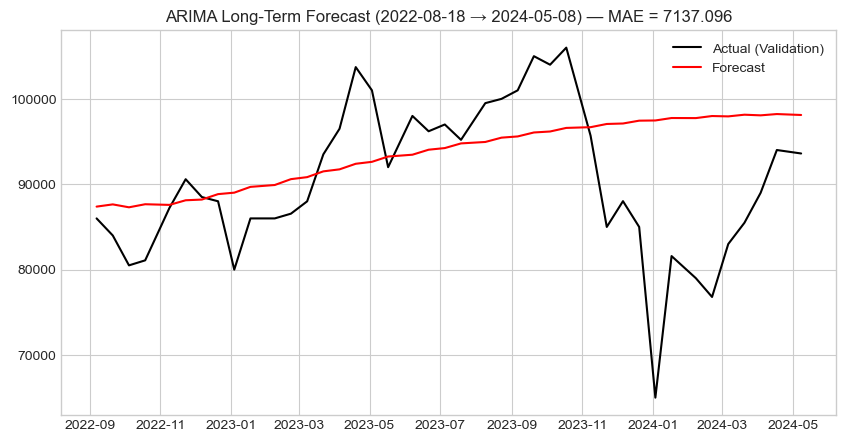

2022-09-07 | Pred=112683.74, Actual=113000.00, Error=316.26
2022-09-21 | Pred=113347.41, Actual=108051.00, Error=5296.41
2022-10-05 | Pred=113994.74, Actual=95856.00, Error=18138.74
2022-10-19 | Pred=114625.30, Actual=110000.00, Error=4625.30
2022-11-09 | Pred=115238.64, Actual=115388.00, Error=149.36
2022-11-23 | Pred=115834.36, Actual=113881.00, Error=1953.36
2022-12-07 | Pred=116412.04, Actual=105501.00, Error=10911.04
2022-12-21 | Pred=116971.28, Actual=108006.00, Error=8965.28
2023-01-04 | Pred=117511.70, Actual=102002.00, Error=15509.70
2023-01-18 | Pred=118032.94, Actual=105459.00, Error=12573.94
2023-02-08 | Pred=118534.63, Actual=105524.00, Error=13010.63
2023-02-22 | Pred=119016.44, Actual=115001.00, Error=4015.44
2023-03-08 | Pred=119478.02, Actual=115501.00, Error=3977.02
2023-03-22 | Pred=119919.07, Actual=116201.00, Error=3718.07
2023-04-05 | Pred=120339.28, Actual=118501.00, Error=1838.28
2023-04-19 | Pred=120738.36, Actual=120889.00, Error=150.64
2023-05-03 | Pred=12111

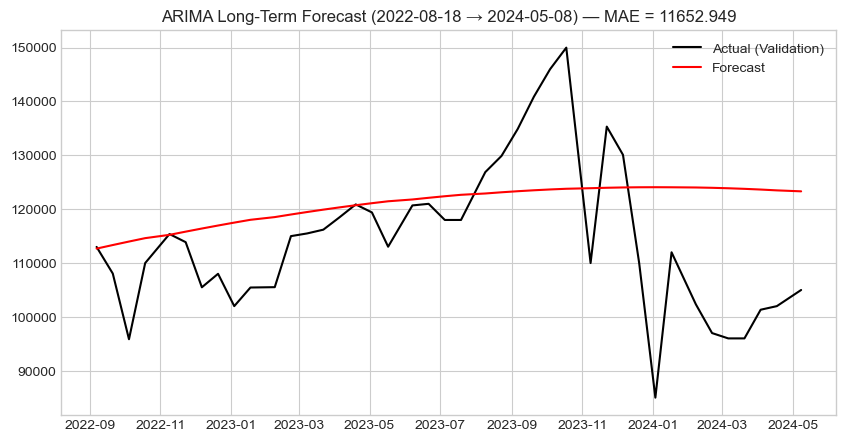

In [32]:
exog_vars = ['sin_1', 'cos_1']  # example

mae, errors, preds, actuals = arima_longterm_validation_exog(
    df_coe_a_exog,
    value_col='Premium',
    start_val_date='2022-08-18',
    end_val_date='2024-05-08',
    exog_cols=exog_vars,
    order=(4,1,2),
    verbose=True,
    plot=True
)

mae, errors, preds, actuals = arima_longterm_validation_exog(
    df_coe_b_exog,
    value_col='Premium',
    start_val_date='2022-08-18',
    end_val_date='2024-05-08',
    exog_cols=exog_vars,
    order=(0,1,1),
    verbose=True,
    plot=True
)

## Testset
- Ungeneralisable Long term Results
- Sin and Cos features are correlated during the val stage. But may not correlate with the long term trend

### Rolling Validation

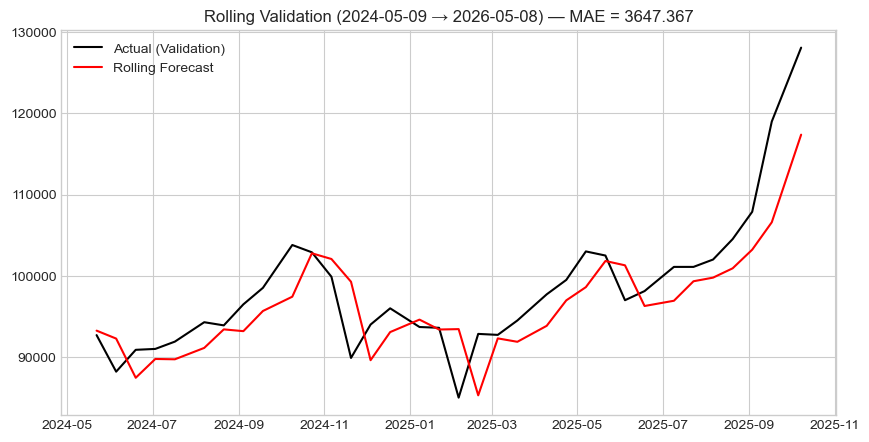

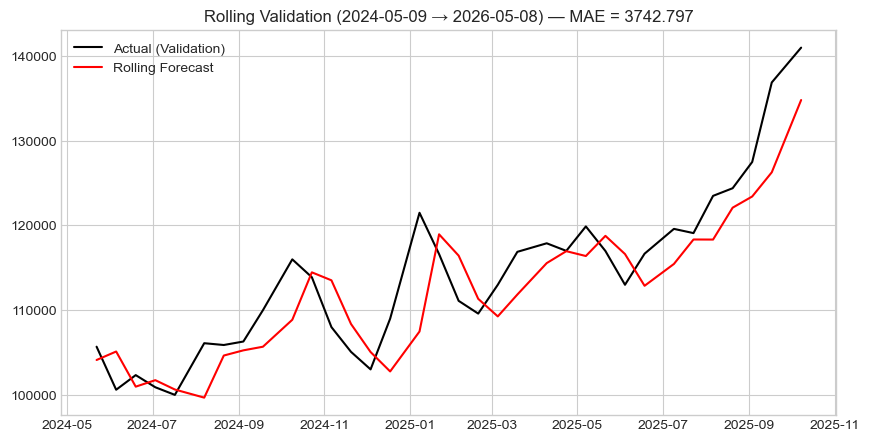

(3742.796982089775,
 [1569.550118330255,
  4513.084945193463,
  1361.9949794754793,
  835.3116118993785,
  632.097729304849,
  6426.799618284887,
  1243.103828266656,
  1042.1343336165446,
  4314.219045302292,
  7132.212422026903,
  579.3380280173878,
  5527.004980517915,
  3290.2546230742737,
  2049.943845927861,
  6233.24667173739,
  14019.168779896077,
  2334.2147699453053,
  5335.694724318295,
  1741.587073731891,
  3734.246211644815,
  5042.556646971076,
  2340.487735800736,
  35.24007084798359,
  3494.539994981431,
  1788.5103703627829,
  3628.483965024614,
  3788.926087755477,
  4140.9184227858495,
  753.7229594023665,
  5159.873582401735,
  2297.0640733413893,
  4075.3549875769677,
  10609.4441658945,
  6184.765987393534],
 [104119.44988166975,
  105120.08494519346,
  100972.00502052452,
  101736.31161189938,
  100632.09772930485,
  99674.20038171511,
  104645.89617173334,
  105257.86566638346,
  105686.78095469771,
  108869.7875779731,
  114469.33802801739,
  113528.0049805179

In [44]:
arima_rolling_validation_exog(df_coe_a_exog, value_col='Premium', start_val_date='2024-05-09', end_val_date='2026-05-08',
                               exog_cols=exog_vars, order=(4,1,2), plot=True
                               )

arima_rolling_validation_exog(df_coe_b_exog, value_col='Premium', 
                         start_val_date='2024-05-09', end_val_date='2026-05-08', exog_cols=exog_vars,
                                             order=(0,1,1), plot=True)

### Long Term

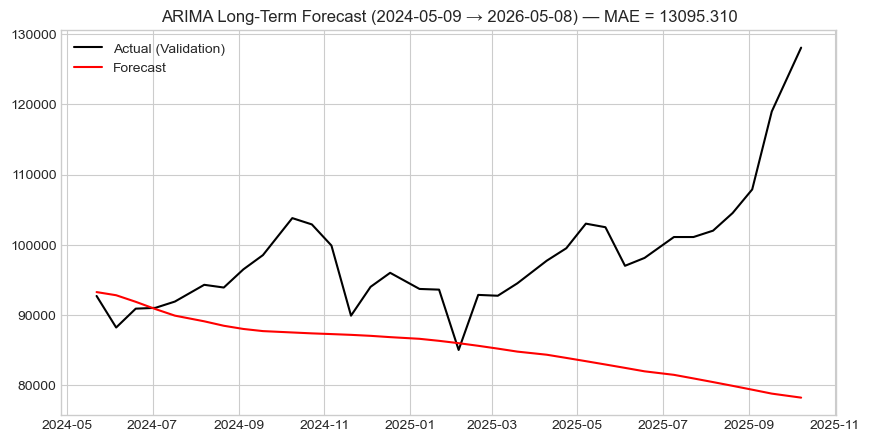

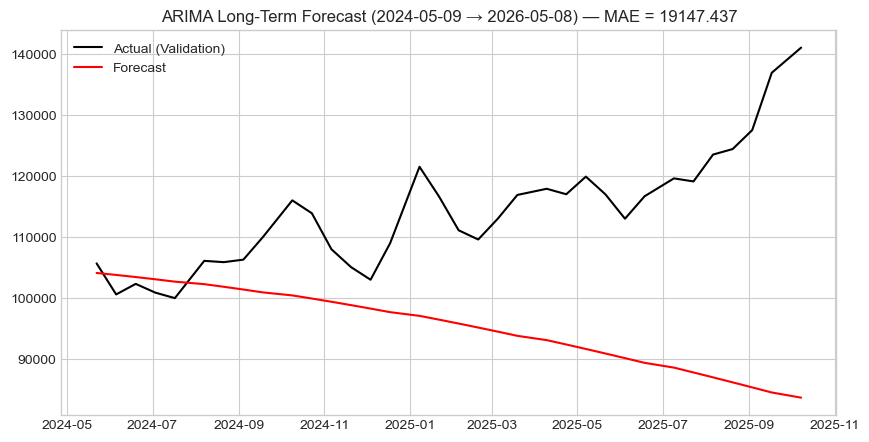

(19147.43671068846,
 array([ 1569.55011833,  3189.78076193,  1118.13144228,  2184.73812817,
         2697.85192725,  3812.26132263,  4030.3212357 ,  4892.03307037,
         9064.08793126, 15556.16298091, 13954.92166099,  8596.01392304,
         6225.07646828,  4721.73299668, 11297.5944648 , 24402.25935247,
        20147.31393792, 15264.33258136, 14412.87801667, 18485.50165113,
        23061.74387278, 24772.13436548, 24592.19243124, 28209.4273196 ,
        26051.33856407, 22820.41632503, 27260.1417392 , 30971.98727523,
        31266.41709524, 36467.88742208, 38184.84691195, 42110.73703235,
        52333.99244477, 57287.04139223]),
 array([104119.44988167, 103796.78076193, 103452.13144228, 103085.73812817,
        102697.85192725, 102288.73867737, 101858.6787643 , 101407.96692963,
        100936.91206874, 100445.83701909,  99935.07833901,  99404.98607696,
         98855.92353172,  98288.26700332,  97702.4055352 ,  97098.74064753,
         96477.68606208,  95839.66741864,  95185.12198333,

In [41]:
arima_longterm_validation_exog(df_coe_a_exog, value_col='Premium', start_val_date='2024-05-09', end_val_date='2026-05-08',
                               exog_cols=exog_vars, order=(4,1,2), plot=True
                               )

arima_longterm_validation_exog(df_coe_b_exog, value_col='Premium', 
                         start_val_date='2024-05-09', end_val_date='2026-05-08', exog_cols=exog_vars,
                                             order=(0,1,1), plot=True)

# Plot of Future Coe prices 1 year into the future


In [14]:
import pandas as pd
from datetime import timedelta

def get_bidding_wednesday(month_date, bidding_no):
    """
    Returns the Wednesday closing date for a given bidding number (1 or 2) in a month.
    """
    # Ensure month_date is the first day of the month
    first_day = month_date.replace(day=1)
    
    # Weekday: Monday=0, Sunday=6
    first_monday = first_day + pd.offsets.Week(weekday=0)
    
    if bidding_no == 1:
        closing_wed = first_monday + timedelta(days=2)
    elif bidding_no == 2:
        third_monday = first_monday + timedelta(weeks=2)
        closing_wed = third_monday + timedelta(days=2)
    else:
        raise ValueError("bidding_no should be 1 or 2")
    
    return closing_wed


def generate_future_biddings(start_date, n_biddings, round_start=True):
    """
    Generates the next `n_biddings` bidding Wednesdays starting from start_date.
    
    Parameters:
    - start_date: datetime-like, reference date to start looking for future biddings
    - n_biddings: total number of future bidding Wednesdays to generate
    - round_start: if True, starts from the next upcoming bidding (not past ones)
    
    Returns:
    - List of datetime objects representing bidding Wednesdays
    """
    from datetime import datetime, timedelta
    import pandas as pd

    start_date = pd.to_datetime(start_date)
    future_biddings = []
    month_cursor = start_date.replace(day=1)
    
    while len(future_biddings) < n_biddings:
        # Compute 1st and 2nd bidding for this month
        b1 = get_bidding_wednesday(month_cursor, 1)
        b2 = get_bidding_wednesday(month_cursor, 2)
        month_biddings = [b1, b2]

        # Only keep biddings after start_date if round_start=True
        for b in month_biddings:
            if round_start:
                if b > start_date:
                    future_biddings.append(b)
            else:
                future_biddings.append(b)

            if len(future_biddings) >= n_biddings:
                break

        # Move to next month
        month_cursor += pd.DateOffset(months=1)

    return future_biddings[:n_biddings]



In [15]:
# Assuming n_periods is 24 (12 months × 2 biddings)
future_biddings = generate_future_biddings(df_coe_a['Bidding_Date'].iloc[-1], n_biddings=240, round_start=True)

# Historical data
df_coe_a_copy['Bidding_Date'] = pd.to_datetime(df_coe_a_copy['Bidding_Date'])
df_coe_b_copy['Bidding_Date'] = pd.to_datetime(df_coe_b_copy['Bidding_Date'])

# Future biddings
future_biddings = pd.to_datetime(future_biddings)


In [16]:
def extend_fourier_features(df_hist, period=365, order=1, n_periods=12):
    """
    Extend Fourier features (sin/cos) for future periods based on historical data length.
    The index continues from the last row of df_hist.

    Parameters
    ----------
    df_hist : pd.DataFrame
        Historical dataframe. Length is used to continue the Fourier series.
    period : int
        Seasonal period (e.g., 365 for yearly, 12 for monthly seasonality).
    order : int
        Number of Fourier pairs (k=1,...,order).
    n_periods : int
        Number of future periods to generate.

    Returns
    -------
    df_future : pd.DataFrame
        DataFrame of future Fourier features with a numeric index continuing from df_hist.
    """
    start_idx = len(df_hist)
    t = np.arange(start_idx, start_idx + n_periods)
    
    data = {}
    for k in range(1, order + 1):
        data[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        data[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    
    df_future = pd.DataFrame(data, index=np.arange(start_idx, start_idx + n_periods))
    return df_future

In [17]:
df_coe_a_exog = df_coe_a_exog.reset_index(drop=True)
df_coe_b_exog = df_coe_b_exog.reset_index(drop=True)

In [25]:
df_coe_a_exog[exog_vars]

,sin_1,cos_1
0,0.000000e+00,1.0
1,-2.449294e-16,1.0
2,-4.898587e-16,1.0
3,-7.347881e-16,1.0
4,-9.797174e-16,1.0
...,...,...
367,4.511404e-14,1.0
368,-2.038208e-13,1.0
369,1.991622e-15,1.0
370,-2.469433e-13,1.0


In [24]:
# --- Fit SARIMAX models directly on raw 'Premium' (d=1 already in order) ---
model_a = SARIMAX(df_coe_a_exog['Premium'], order=(2,1,3), exog=df_coe_a_exog[exog_vars],
                  seasonal_order=(0,0,0,0), enforce_stationarity=True, enforce_invertibility=True)
results_a = model_a.fit(disp=False)

model_b = SARIMAX(df_coe_b_exog['Premium'], order=(2,1,2), 
                  seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
results_b = model_b.fit(disp=False)

# --- Forecast in original scale ---
n_periods = 240
alpha = 0.05

future_fourier = extend_fourier_features(df_coe_a_exog, 240, 1, n_periods)
# print(df_coe_a_exog.index)
print(future_fourier)
forecast_a = results_a.get_forecast(steps=240, exog=future_fourier)
# print(df_coe_a_exog)
preds_a = forecast_a.predicted_mean
# print(preds_a)
ci_a = forecast_a.conf_int(alpha=alpha)

forecast_b = results_b.get_forecast(steps=n_periods)
preds_b = forecast_b.predicted_mean
# print(preds_b)
ci_b = forecast_b.conf_int(alpha=alpha)



c:\Users\pecke\anaconda3\envs\llms\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


        sin_1     cos_1
372 -0.309017 -0.951057
373 -0.333807 -0.942641
374 -0.358368 -0.933580
375 -0.382683 -0.923880
376 -0.406737 -0.913545
..        ...       ...
607 -0.182236 -0.983255
608 -0.207912 -0.978148
609 -0.233445 -0.972370
610 -0.258819 -0.965926
611 -0.284015 -0.958820

[240 rows x 2 columns]


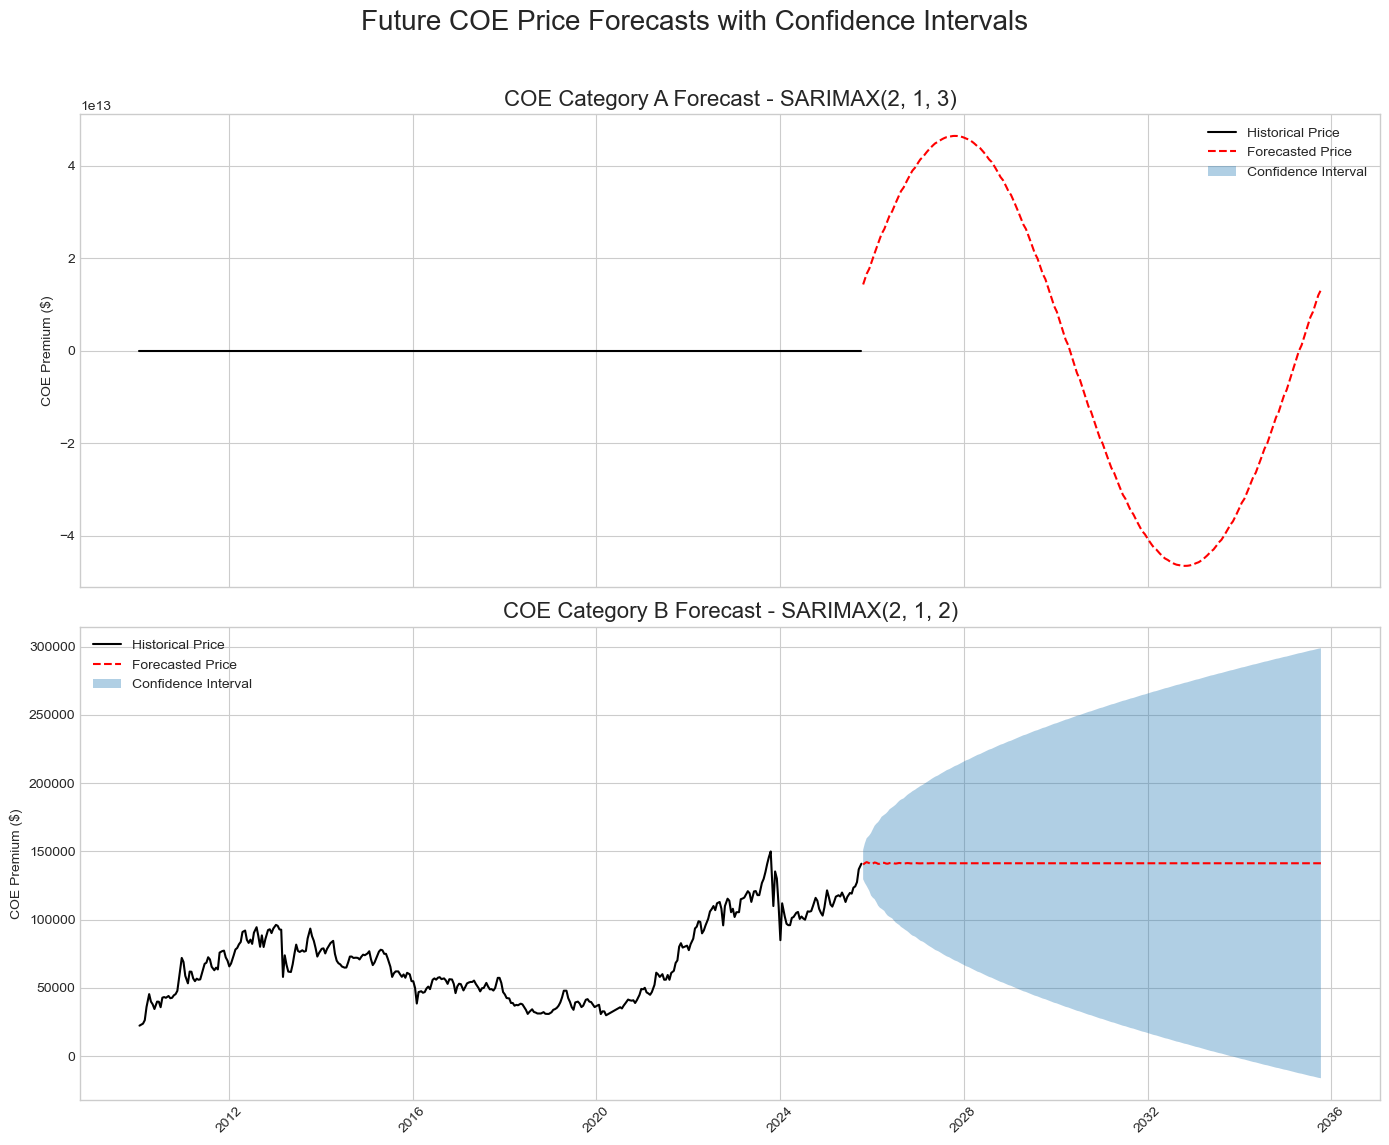

In [23]:
# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

def plot_forecast(ax, df_hist, preds, ci, forecast_dates, title):
    """
    Plots historical prices and forecasted prices with confidence intervals.
    df_hist: historical dataframe with 'Bidding_Date' and 'Premium'
    preds: forecasted values
    ci: confidence intervals
    forecast_dates: future dates corresponding to preds/ci
    """
    # Ensure all dates are datetime
    hist_dates = pd.to_datetime(df_hist['Bidding_Date'])
    forecast_dates = pd.to_datetime(forecast_dates)
    # print(hist_dates.values)
    # Plot historical prices
    ax.plot(hist_dates.values, df_hist['Premium'].values, label='Historical Price', color='black')

    # Plot forecasted prices
    ax.plot(forecast_dates.values, preds, label='Forecasted Price', color='red', linestyle='--')

    # Plot confidence intervals
    ax.fill_between(forecast_dates.values, ci.iloc[:,0].values, ci.iloc[:,1].values, 
                    alpha=0.35, label='Confidence Interval')

    # Formatting
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("COE Premium ($)")
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis_date()  # ensures datetime x-axis
# print(future_biddings)
future_biddings = pd.to_datetime(future_biddings)
# Plot forecasts

df_coe_a_exog['Bidding_Date'] = pd.to_datetime(df_coe_a_exog['Bidding_Date'])
df_coe_b_exog['Bidding_Date'] = pd.to_datetime(df_coe_b_exog['Bidding_Date'])

plot_forecast(
    axes[0], df_coe_a_exog, preds_a, ci_a, future_biddings, 
    f"COE Category A Forecast - SARIMAX{(2, 1, 3)}"
)

plot_forecast(
    axes[1], df_coe_b_exog, preds_b, ci_b, future_biddings, 
    f"COE Category B Forecast - SARIMAX{(2, 1, 2)}"
)

plt.suptitle("Future COE Price Forecasts with Confidence Intervals", fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()